In [208]:
##############################################################
### Set up libraries and global variables
##############################################################
 
import pandas as pd
pd.options.mode.chained_assignment = None    # no warning message and no exception is raised
import numpy as np
import matplotlib.pyplot as plt
import scipy

#github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_30/data/"
github_location = "./data/"
#github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_styles = "./styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

molwtH2SO4 = 98.079
molwtH2O = 18.015
densityH2SO4 = 1.83
densityH2O = 1.00


In [209]:
def make_interpolator_p_vs_w(Data_File_Name = "models/p-model.csv", w_column = "w", p_column = "p"):
    '''Requires a data file of density and %H2SO4 values and the names of the columns in that file.
    Returns an interpolation function that predicts density (p) when given %H2SO4 (w)
    Uses a data file that must be accessible. Ensure that "models/p-model.csv" is accessible.
    Edit the file path if needed.'''

    # Get Density data and make interpolation model
    Filename = github_location + Data_File_Name
    df = pd.read_csv(Filename, 
                     delimiter = ",", 
                     skipinitialspace=True, 
                     index_col=False, 
                     comment = "#") 
    w = df[w_column]
    p = df[p_column]

    # Create interpolator function where a value of density is returned when given value of %H2SO4
    density_interpolator_w = scipy.interpolate.make_interp_spline(w,p)
    return density_interpolator_w

def make_interpolator_p_vs_M(Data_File_Name = "models/p-model.csv", w_column = "w", p_column = "p"):
    '''equires a data file of density and %H2SO4 values and the names of the columns 
    in that file. Returns an interpolation function that predicts density (p) when given 
    molar conc. of H2SO4 (moles/L). Uses a data file that must be accessible. 
    Ensure that "models/p-model.csv" is accessible. Edit the file path if needed.'''

    molwtH2SO4 = 98.079
    molwtH2O = 18.015
    densityH2SO4 = 1.83
    densityH2O = 1.00

    # Get Density data and make interpolation model
    Filename = github_location + Data_File_Name
    df = pd.read_csv(Filename, 
                     delimiter = ",", 
                     skipinitialspace=True, 
                     index_col=False, 
                     comment = "#") 
    w = df[w_column]
    p = df[p_column]

    moles_H2SO4_in_100g = w / molwtH2SO4                # moles of H2SO4 in 100 g of mixture from % wt
    volume_of_100g = 100 / p                            # volume in cm^3
    M = moles_H2SO4_in_100g / volume_of_100g * 1000     # 1000 cm^3/L

    # Create interpolator function where a value of density is returned when given value of molar H2SO4
    density_interpolator_M = scipy.interpolate.make_interp_spline(M,p)
    return density_interpolator_M

density_interpolator_wH2SO4 = make_interpolator_p_vs_w()
density_interpolator_MH2SO4 = make_interpolator_p_vs_M()

def convert_x_to_m(x):
    '''Takes mole fraction (x) of H2SO4 and converts to molal conc (moles/kg) of H2SO4
   '''
    molwtH2SO4 = 98.079
    molwtH2O = 18.015
    return (x / (1 - x)) * (1000 / molwtH2O)   # moles H2SO4 per kg H20

def convert_m_to_x(m):
    '''Takes molal conc (moles/kg) of H2SO4 and converts to mole fraction (x) of H2SO4
    '''
    molwtH2SO4 = 98.079
    molwtH2O = 18.015
    return m / (m + (1000 / molwtH2O))   # mole fraction H2SO4

def convert_x_to_w(x):
    '''Takes mole fraction (x) of H2SO4 and converts to w (%mass H2SO4)
   '''
    molwtH2SO4 = 98.079
    molwtH2O = 18.015
    return x*molwtH2SO4 / (x*molwtH2SO4 + (1-x)*molwtH2O) * 100  # w (%H2SO4)

def convert_w_to_x(w):
    '''Takes w (%mass H2SO4) and converts to mole fraction (x) of H2SO4
   '''
    molwtH2SO4 = 98.079
    molwtH2O = 18.015
    return (w / molwtH2SO4) / ( (w / molwtH2SO4) + ((100 - w) / molwtH2O) )   # mole fraction H2SO4 

def convert_m_to_w(m):
    '''Takes molal conc (moles/kg) of H2SO4 and converts to w (%mass H2SO4)
   '''
    molwtH2SO4 = 98.079
    molwtH2O = 18.015
    return (m*molwtH2SO4) / ((m*molwtH2SO4) + 1000) * 100   # w (%H2SO4)

def convert_w_to_m(w):
    '''Takes w (%mass H2SO4) and converts to molal conc (moles/kg) of H2SO4 
   '''
    molwtH2SO4 = 98.079
    molwtH2O = 18.015
    return (w/molwtH2SO4)/(100 - w) * 1000  # moles H2SO4 per gram H20 * 1000g/kg 

def molar_H2O_from_w(w):
    '''Calulate molar conc of H2O in H2SO4'''
    molwtH2SO4 = 98.079
    molwtH2O = 18.015

    m = convert_w_to_m(w)                                # molal conc of H2SO4
    moles_H2O = 1000/molwtH2O                            # moles of water
    density = density_interpolator_wH2SO4(w)             # interpolated density of mixture a value of w
    total_mass = m*molwtH2SO4 + 1000                     # total mass of mixture
    volume = total_mass / density /1000                  # volume in litres
    molar_H2O = moles_H2O/volume                         # moles H20 / volume of system = conc in M
    return molar_H2O


def convert_aH2O_pxp0_to_MxM0(w, aH2O):
    '''Converts activity of water from partial pressure units to Molar units
    requires array of  %H2SO4, array of partial pressure values 
    and corresponding array of densities of the mixture'''

    molwtH2SO4 = 98.079
    molwtH2O = 18.015

    mfH2O = ((100-w)/molwtH2O) / (w/molwtH2SO4 + (100-w)/molwtH2O)   # mole fraction H2O
    gamma = aH2O / mfH2O                                 # apparent activity coeff H2O

    molar_H2O = molar_H2O_from_w(w)                     # moles H20 / volume of system = conc in M
    molar_a_H2O = molar_H2O * gamma                      # molar activity of water
    return molar_a_H2O

def convert_osmotic_to_aH2O(m, osm_coeff):
    v = 3                                      # dissociation # for H2SO4
    M = 18.015                                 # mole wt water
    ln_aH2O = osm_coeff / (-1000/(v*m*M))
    return np.exp(ln_aH2O)

convert_m_to_w(10)
convert_w_to_m(49.515092463108154)

10.000000000000002

In [210]:


# Get a_H2O data from Giauque and Rard

Data_File_Name = "models/aH2O_model.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 
m = df["m"].to_numpy()
aH2O = df["aH2O"].to_numpy()

w = convert_m_to_w(m)
molar_a_H2O = convert_aH2O_pxp0_to_MxM0(w, aH2O)

df1 = pd.DataFrame({"w":w,
              "M_aH2O": molar_a_H2O})
df1

,w,M_aH2O
0,0.971264,55.065058
1,1.923842,54.783470
2,2.858269,54.490071
3,3.775058,54.189106
4,4.674705,53.885198
...,...,...
74,95.149351,0.000725
75,96.713089,0.000295
76,97.514392,0.000163
77,98.001579,0.000106


In [211]:
# get data from Cox

Data_File_Name = "01_Cox_Table3_activityH2OinH2SO4.csv"

Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

w = df["%H2SO4"].to_numpy()
log_aH2O = df["log aH2O"].to_numpy()

df_cox_T3 = pd.DataFrame({"w":w,
              "M_aH2O": np.power(10, log_aH2O)})


In [212]:
## get data from Cox
#
#Data_File_Name = "01_Cox_Table4_activityH2OinH2SO4.csv"
#
#Filename = github_location + Data_File_Name
#
#df = pd.read_csv(Filename, 
#                 delimiter = ",", 
#                 skipinitialspace=True, 
#                 index_col=False, 
#                 comment = "#") 
#
#M = df["conc H2SO4 / (mole/L)"].to_numpy()
#log_aH2O = df["log aH2O"].to_numpy()
#
#density_interpolator_M = make_interpolator_p_vs_M("models/p-model.csv", w_column = "w", p_column = "p")
#density = density_interpolator_M(M)          # Density at each molar concentration
#
#mass_of_1L = 1000 * density                  # g of 1 litre og mixture
#mass_of_H2SO4_in_1L = M * molwtH2SO4
#w = mass_of_H2SO4_in_1L / mass_of_1L * 100
#
#
#
#
#df_cox_T4 = pd.DataFrame({"w":w,
#              "M_aH2O": np.power(10, log_aH2O)})
#
#########################################################

# get data from Cox

Data_File_Name = "01_Cox_Table4_activityH2OinH2SO4.csv"

Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

M = df["conc H2SO4 / (mole/L)"].to_numpy()
log_aH2O = df["log aH2O"].to_numpy()

density = density_interpolator_MH2SO4(M)          # Density at each molar concentration



mass_of_1L = 1000 * density                  # g of 1 litre og mixture
mass_of_H2SO4_in_1L = M * molwtH2SO4
w = mass_of_H2SO4_in_1L / mass_of_1L * 100




df_cox_T4 = pd.DataFrame({"w":w,
              "M_aH2O": np.power(10, log_aH2O)})

w

array([9.83030142e-02, 9.77225008e-01, 2.42017765e+00, 4.76825020e+00,
       7.04778284e+00, 9.26228881e+00, 1.35127713e+01, 1.75436201e+01,
       2.13778524e+01, 2.50355167e+01, 2.85315695e+01, 3.18839534e+01,
       3.51064079e+01, 3.82056295e+01, 4.11913294e+01, 4.40721322e+01,
       4.68440785e+01, 4.95197798e+01, 5.20995925e+01, 5.45987405e+01,
       5.70133202e+01, 5.93592333e+01, 6.16354368e+01, 6.38487922e+01,
       6.60042356e+01, 6.81056253e+01, 7.01564065e+01, 7.21585862e+01,
       7.41213056e+01, 7.60464298e+01, 7.79435406e+01, 7.98252484e+01,
       8.17043113e+01, 8.35931868e+01, 8.55154842e+01, 8.75038982e+01,
       8.95718543e+01, 9.17317623e+01, 9.39972671e+01, 9.64173119e+01,
       9.92309799e+01])

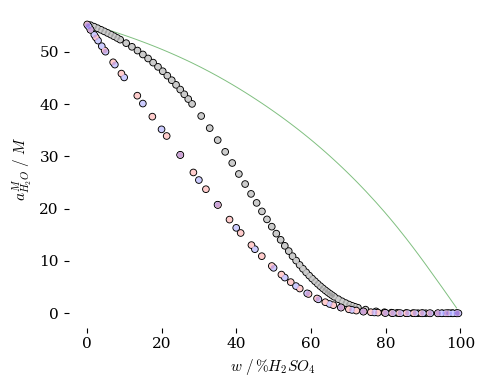

In [213]:
style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$a^M_{H_2O}\ /\;M$" 

ax.set(
#          title = Title0,       
          ylabel=y_label, 
          xlabel=x_label,                
#          xlim=[-2,102],                  
#          ylim=[1,-13]
       )

x = df1["w"]
molar_H2O = molar_H2O_from_w(x)
y = np.log10(molar_H2O)
y = molar_H2O

ax.plot(x, y, 
          marker = None,  
          color = "green", linewidth=0.7, 
          alpha = 0.5,
          zorder = 0)

x = df1["w"]
y = np.log10(df1["M_aH2O"])
y = df1["M_aH2O"]

ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 3)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 4)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "black", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 5)



x = df_cox_T4["w"]
y = np.log10(df_cox_T4["M_aH2O"])
y = df_cox_T4["M_aH2O"]

ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 6)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 7)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "red", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 8)

x = df_cox_T3["w"]
y = np.log10(df_cox_T3["M_aH2O"])
y = df_cox_T3["M_aH2O"]

ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 6)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 7)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "blue", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 8)



plt.savefig("plots/plot_H1.pdf")
plt.show()


In [214]:
theta = 0.6796
m = 0.1
v = 3
M = 18.015
A = -1000/(v*m*M)
ln_aw = theta/A
aw = np.exp(ln_aw)
aw



0.9963338386401606

69   -1.504303
70   -1.780333
71   -2.001679
72   -2.179607
73   -2.330743
74   -3.139446
75   -3.529730
76   -3.787322
77   -3.975930
78   -4.534161
Name: M_aH2O, dtype: float64
31    79.825248
32    81.704311
33    83.593187
34    85.515484
35    87.503898
36    89.571854
37    91.731762
38    93.997267
39    96.417312
40    99.230980
Name: w, dtype: float64
30   -2.492
31   -2.854
32   -3.197
33   -3.504
34   -3.646
35   -3.796
36   -3.990
37   -4.303
38   -4.894
39   -5.421
Name: M_aH2O, dtype: float64


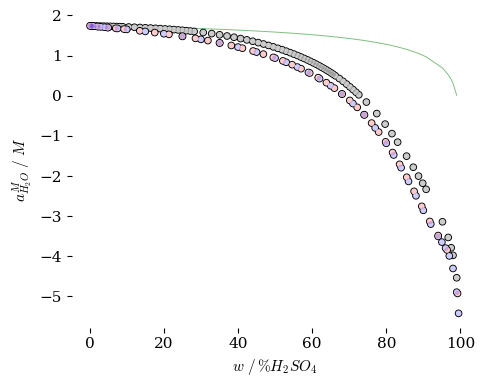

In [215]:
style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$a^M_{H_2O}\ /\;M$" 

ax.set(
#          title = Title0,       
          ylabel=y_label, 
          xlabel=x_label,                
#          xlim=[-2,102],                  
#          ylim=[1,-13]
       )

x = df1["w"]
molar_H2O = molar_H2O_from_w(x)
y = np.log10(molar_H2O)
#y = molar_H2O


ax.plot(x, y, 
          marker = None,  
          color = "green", linewidth=0.7, 
          alpha = 0.5,
          zorder = 0)



x = df1["w"]
y = np.log10(df1["M_aH2O"])
#y = df1["M_aH2O"]
print(y[-10:])
ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 3)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 4)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "black", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 5)



x = df_cox_T4["w"]
y = np.log10(df_cox_T4["M_aH2O"])
#y = df_cox_T4["M_aH2O"]
print(x[-10:])
ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 6)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 7)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "red", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 8)

x = df_cox["w"]
y = np.log10(df_cox["M_aH2O"])
#y = df_cox["M_aH2O"]
print(y[-10:])
ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 6)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 7)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "blue", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 8)



plt.savefig("plots/plot_H2.pdf")
plt.show()


## Osmotic Coefficient to $a_w$

In [216]:

convert_osmotic_to_aH2O(27, 2.4353)

# get data from Zelznik

Data_File_Name = "01_Zeleznik_Table8_activityH2OinH2SO4.csv"

Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 
m = df["m"].to_numpy()
osmotic_coeff = df["phi_25"].to_numpy()

w_z = convert_m_to_w(m)

a_H2O = convert_osmotic_to_aH2O(m, osmotic_coeff)
molar_a_H2O_z = convert_aH2O_pxp0_to_MxM0(w_z, a_H2O)
print(np.log10(molar_a_H2O_z))

print((m))

df_Z_T8 = pd.DataFrame({"m":m,
                        "theta": osmotic_coeff,
                        "aH2O": a_H2O,
                       "M_aH2O": molar_a_H2O_z,
                       "w": w_z}
                       )

df_Z_T8.to_csv("data/temp.csv")

[ 1.7428426   1.74260604  1.74237169  1.74213926  1.74190809  1.74167801
  1.74144892  1.7412204   1.74099253  1.74076488  1.73849365  1.73619659
  1.7338667   1.73151518  1.72913473  1.72668389  1.72415166  1.72156232
  1.71890182  1.70419601  1.68724256  1.66815264  1.64700498  1.62404
  1.59944164  1.57331455  1.54585012  1.51722732  1.48756641  1.45700709
  1.42566018  1.39358755  1.36089591  1.32770352  1.29407292  1.26002813
  1.22559839  1.19088995  1.15593466  1.12069042  1.08527715  1.04965047
  1.01395377  0.97812196  0.94215045  0.90614138  0.87007049  0.83398833
  0.79788532  0.76178683  0.72568788  0.68962048  0.65362052  0.61768108
  0.58182391  0.54602754  0.51032957  0.474714    0.43925094  0.40386705
  0.36868785  0.33357849  0.29865779  0.26389575  0.22926187  0.19483299
  0.16057036  0.12648986  0.09260621  0.05887208  0.02536333 -0.00790322
 -0.04104175 -0.07390604 -0.10661234 -0.13901075 -0.17129847]
[1.00e-02 2.00e-02 3.00e-02 4.00e-02 5.00e-02 6.00e-02 7.00e-02 8

69   -1.504303
70   -1.780333
71   -2.001679
72   -2.179607
73   -2.330743
74   -3.139446
75   -3.529730
76   -3.787322
77   -3.975930
78   -4.534161
Name: M_aH2O, dtype: float64
31    79.825248
32    81.704311
33    83.593187
34    85.515484
35    87.503898
36    89.571854
37    91.731762
38    93.997267
39    96.417312
40    99.230980
Name: w, dtype: float64
30   -2.492
31   -2.854
32   -3.197
33   -3.504
34   -3.646
35   -3.796
36   -3.990
37   -4.303
38   -4.894
39   -5.421
Name: M_aH2O, dtype: float64
[ 0.12648986  0.09260621  0.05887208  0.02536333 -0.00790322 -0.04104175
 -0.07390604 -0.10661234 -0.13901075 -0.17129847]
[71.43685066 71.8314144  72.21522586 72.58871867 72.95230342 73.30636921
 73.65128503 73.98740106 74.3150498  74.63454724]


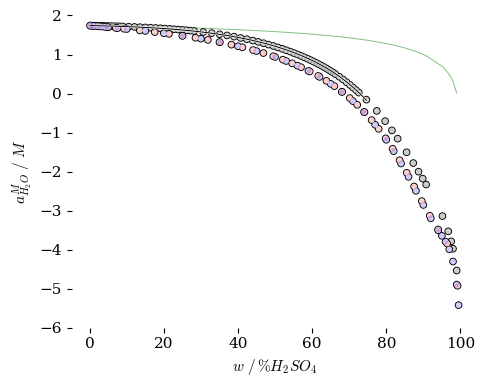

In [217]:
style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$a^M_{H_2O}\ /\;M$" 

ax.set(
#          title = Title0,       
          ylabel=y_label, 
          xlabel=x_label,                
#          xlim=[-2,102],                  
          ylim=[-6,2]
       )

x = df1["w"]
molar_H2O = molar_H2O_from_w(x)
y = np.log10(molar_H2O)
#y = molar_H2O


ax.plot(x, y, 
          marker = None,  
          color = "green", linewidth=0.7, 
          alpha = 0.5,
          zorder = 0)



x = df1["w"]
y = np.log10(df1["M_aH2O"])
#y = df1["M_aH2O"]
print(y[-10:])
ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 3)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 4)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "black", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 5)



x = df_cox_T4["w"]
y = np.log10(df_cox_T4["M_aH2O"])
#y = df_cox_T4["M_aH2O"]
print(x[-10:])
ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 6)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 7)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "red", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 8)

x = df_cox["w"]
y = np.log10(df_cox["M_aH2O"])
#y = df_cox["M_aH2O"]
print(y[-10:])
ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 6)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 7)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "blue", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 8)


x = w_z
y = np.log10(molar_a_H2O_z)
#y = molar_a_H2O_z
print(y[-10:])
print(x[-10:])
ax.plot(x, y, 
          marker = None,  
          color = "white", linewidth=1.5, 
          alpha = 1,
          zorder = 10)
ax.plot(x, y, 
          marker = None,  
          color = "black", linewidth=0.7, 
          alpha = 1,
          zorder = 10)



plt.savefig("plots/plot_H3.pdf")
plt.show()


In [218]:
## Convert u_r data from figure 25 of Zeleznick to osmitic coefficient and then to activity
## https://en.wikipedia.org/wiki/Thermodynamic_activity


Data_File_Name = "01-Zeleznick_F25B_scanned.csv"

Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

x = df["x"].to_numpy()
ur = df["u_r"].to_numpy()

a_w = np.exp(-ur)

w2 = convert_x_to_w(x)
molar_a_H2O_z2 = convert_aH2O_pxp0_to_MxM0(w2, a_w)
help(convert_aH2O_pxp0_to_MxM0)

Help on function convert_aH2O_pxp0_to_MxM0 in module __main__:

convert_aH2O_pxp0_to_MxM0(w, aH2O)
    Converts activity of water from partial pressure units to Molar units
    requires array of  %H2SO4, array of partial pressure values
    and corresponding array of densities of the mixture



In [219]:
x = .1

x / (x + (1 - x) * (molwtH2O / molwtH2SO4)) * 100  # convert to w %H2SO4

convert_x_to_w(x)

37.69166916461067

In [220]:
x = .1 # mole fraction H2SO4

# convert molefraction H2SO4 to m molality
massH2O = (1 - x) * molwtH2O
molesH2SO4 = x 
m = molesH2SO4 / massH2O * 1000  # molality

convert_x_to_m(x)
convert_m_to_x(10)

0.1526500868533661

In [221]:
x2 = .5
x1 = 1-x2

du_RT = 11.52

theta = du_RT/(3*x1/x2)
theta

3.84

69   -1.504303
70   -1.780333
71   -2.001679
72   -2.179607
73   -2.330743
74   -3.139446
75   -3.529730
76   -3.787322
77   -3.975930
78   -4.534161
Name: M_aH2O, dtype: float64
31    79.825248
32    81.704311
33    83.593187
34    85.515484
35    87.503898
36    89.571854
37    91.731762
38    93.997267
39    96.417312
40    99.230980
Name: w, dtype: float64
30   -2.492
31   -2.854
32   -3.197
33   -3.504
34   -3.646
35   -3.796
36   -3.990
37   -4.303
38   -4.894
39   -5.421
Name: M_aH2O, dtype: float64
[ 0.12648986  0.09260621  0.05887208  0.02536333 -0.00790322 -0.04104175
 -0.07390604 -0.10661234 -0.13901075 -0.17129847]
[71.43685066 71.8314144  72.21522586 72.58871867 72.95230342 73.30636921
 73.65128503 73.98740106 74.3150498  74.63454724]


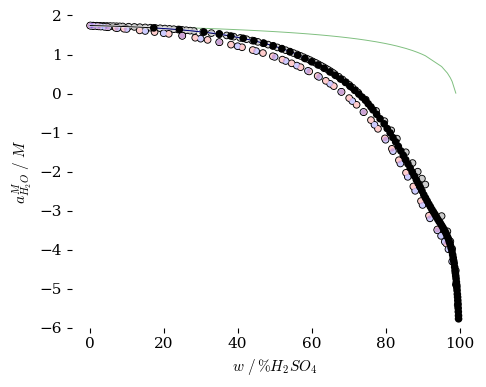

In [222]:
style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$a^M_{H_2O}\ /\;M$" 

ax.set(
#          title = Title0,       
          ylabel=y_label, 
          xlabel=x_label,                
#          xlim=[-2,102],                  
          ylim=[-6,2]
       )



x = w2
y = np.log10(molar_a_H2O_z2)
#y = molar_a_H2O_z2


ax.plot(x, y, 
          marker = None,  
          color = "blue", linewidth=0.7, 
          alpha = 0.5,
          zorder = 11)
ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 12)






x = df1["w"]
molar_H2O = molar_H2O_from_w(x)
y = np.log10(molar_H2O)
#y = molar_H2O


ax.plot(x, y, 
          marker = None,  
          color = "green", linewidth=0.7, 
          alpha = 0.5,
          zorder = 0)



x = df1["w"]
y = np.log10(df1["M_aH2O"])
#y = df1["M_aH2O"]
print(y[-10:])
ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 3)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 4)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "black", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 5)



x = df_cox_T4["w"]
y = np.log10(df_cox_T4["M_aH2O"])
#y = df_cox_T4["M_aH2O"]
print(x[-10:])
ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 6)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 7)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "red", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 8)

x = df_cox["w"]
y = np.log10(df_cox["M_aH2O"])
#y = df_cox["M_aH2O"]
print(y[-10:])
ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 6)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 7)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "blue", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 8)


x = w_z
y = np.log10(molar_a_H2O_z)
#y = molar_a_H2O_z
print(y[-10:])
print(x[-10:])
ax.plot(x, y, 
          marker = None,  
          color = "white", linewidth=1.5, 
          alpha = 1,
          zorder = 10)
ax.plot(x, y, 
          marker = None,  
          color = "black", linewidth=0.7, 
          alpha = 1,
          zorder = 10)



plt.savefig("plots/plot_H3.pdf")
plt.show()


30    88.0
31    90.0
32    92.0
33    94.0
34    95.0
35    96.0
36    97.0
37    98.0
38    99.0
39    99.5
Name: w, dtype: float64
[ 0.12648986  0.09260621  0.05887208  0.02536333 -0.00790322 -0.04104175
 -0.07390604 -0.10661234 -0.13901075 -0.17129847]
[71.43685066 71.8314144  72.21522586 72.58871867 72.95230342 73.30636921
 73.65128503 73.98740106 74.3150498  74.63454724]


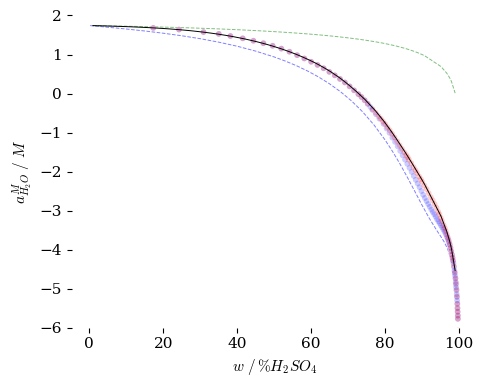

In [233]:
### Plot scanned data for Giauque and Zeleznick fro Zeleznick paper Figure 25B

######################################################
### get data from Zeleznick scan of figure 25B
######################################################

## Convert u_r data from figure 25 of Zeleznick to osmitic coefficient and then to activity
## https://en.wikipedia.org/wiki/Thermodynamic_activity

###################################################### read data
Data_File_Name = "01-Zeleznick_F25B_scanned.csv"     # data file name
Filename = github_location + Data_File_Name          # location of data file

df = pd.read_csv(Filename,                           # read data file
                 delimiter = ",",                    # delimiter is comma for csv
                 skipinitialspace=True,              # skip spaces after delimiter
                 index_col=False,                    # no index column
                 comment = "#"                       # comment character
                 ) 

###################################################### extract data and convert
x = df["x"].to_numpy()                               # mole fraction H2SO4
w2 = convert_x_to_w(x)                               # convert to w %H2SO4

ur = df["u_r"].to_numpy()                            # reduced chemical potential
a_w = np.exp(-ur)                                    # Chemical potential to aH2O_pxp0 activity
molar_a_H2O_z2 = convert_aH2O_pxp0_to_MxM0(w2, a_w)  # convert aH2O to molar activity of H2O (aH2O_MxM0)

###################################################### store results in dataframe
df_Z_F25B_Z = pd.DataFrame({"w":w2,                  # %H2So4
                            "c": molar_a_H2O_z2})    # molar activity of H2O (aH2O_MxM0)

######################################################
### get Giaque data from Zeleznick scan of figure 25B
######################################################

## Convert u_r data from figure 25 of Zeleznick to osmitic coefficient and then to activity
## https://en.wikipedia.org/wiki/Thermodynamic_activity

###################################################### read data
Data_File_Name = "01-Zeleznick_F25B_scanned_giauque.csv"     # data file name
Filename = github_location + Data_File_Name          # location of data file

df = pd.read_csv(Filename,                           # read data file
                 delimiter = ",",                    # delimiter is comma for csv
                 skipinitialspace=True,              # skip spaces after delimiter
                 index_col=False,                    # no index column
                 comment = "#"                       # comment character
                 ) 

###################################################### extract data and convert
x = df["x"].to_numpy()                               # mole fraction H2SO4
w2 = convert_x_to_w(x)                               # convert to w %H2SO4

ur = df["u_r"].to_numpy()                            # reduced chemical potential
a_w = np.exp(-ur)                                    # Chemical potential to aH2O_pxp0 activity
molar_a_H2O_z2 = convert_aH2O_pxp0_to_MxM0(w2, a_w)  # convert aH2O to molar activity of H2O (aH2O_MxM0)

###################################################### store results in dataframe
df_Z_F25B_G = pd.DataFrame({"w":w2,                  # %H2SO4
                            "c": molar_a_H2O_z2})    # molar activity of H2O (aH2O_MxM0)



######################################################
### Plot scanned data for Giauque and Zeleznick fro Zeleznick paper Figure 25B
######################################################

###################################################### set up plot figure, axes and labels
style = "tufte.mplstyle"                             # style file name
style_name = github_location_styles + style          # full path to style file 
plt.style.use(style_name)                            # use style file

fig, ax = plt.subplots(nrows=1, ncols=1,             # create figure and axes
                       figsize=(5,4))                # figure size

ax.set(                                              # set plot parameters
#          title = Title0,                            # plot title
          xlabel=r"$w\ /\,\%H_2SO_4$",               # x axis label                
          ylabel=r"$a^M_{H_2O}\ /\;M$",              # y axis label 
#          xlim=[-2,102],                             # x axis limits
          ylim=[-6,2]                                # y axis limits
       )

###################################################### plot Zeleznick scanned data
x = df_Z_F25B_Z["w"]                                 # %H2SO4
y = np.log10(df_Z_F25B_Z["c"])                       # molar activity of H2O (aH2O_MxM0)
#y = df_Z_F25B_Z["c"]

#ax.plot(x, y,                                        # plot line
#          marker = None,  
#          color = "blue", linewidth=0.7, 
#          alpha = 1,
#          zorder = 1)
if 1:                                                # only plot points if needed
#    ax.scatter(x, y,                                  
#          marker = "o", s = 30, 
#          color = "blue", edgecolors = "none", linewidths=0, 
#          zorder = 3)
    ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 4)
    ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "blue", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 5)



###################################################### plot Giauque scanned data from Zeleznick
x = df_Z_F25B_G["w"]                                 # %H2SO4
y = np.log10(df_Z_F25B_G["c"])                       # molar activity of H2O (aH2O_MxM0)
#y = df_Z_F25B_G["c"]

#ax.plot(x, y,                                        # plot line
#          marker = None,  
#          color = "red", linewidth=0.7, 
#          alpha = 1,
#          zorder = 1)
if 1:                                                # only plot points if needed
#    ax.scatter(x, y,                                  
#          marker = "o", s = 30, 
#          color = "red", edgecolors = "none", linewidths=0, 
#          zorder = 3)
    ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 4)
    ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "red", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 5)



###################################################### plot molar concentration of water
x = df1["w"]                                         # set x-axis to %H2SO4
molar_H2O = molar_H2O_from_w(x)                      # calculate molar concentration of H2O
y = np.log10(molar_H2O)                              # set y-axis to log10 of molar concentration of H2O
#y = molar_H2O                                       # or set y-axis to molar concentration of H2O

ax.plot(x, y, 
          marker = None,  
          color = "green", linewidth=0.7, linestyle='--',
          alpha = 0.5,
          zorder = 0)


###################################################### plot Giauque literature data points
x = df1["w"]                                         # set x-axis to %H2SO4
y = np.log10(df1["M_aH2O"])                          # set y-axis to log10 of molar activity of H2O
#y = df1["M_aH2O"]                                   # or set y-axis to molar activity of H2O
#print(y[-10:])

ax.plot(x, y,                                        # plot line
          marker = None,  
          color = "black", linewidth=0.7, linestyle='-',
          alpha = 1,
          zorder = 11)
if 0:                                                # only plot points if needed
    ax.scatter(x, y,                                  
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 3)
    ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 4)
    ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "black", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 5)


###################################################### plot Cox literature data points
x = df_cox_T3["w"]
y = np.log10(df_cox_T3["M_aH2O"])
#y = df_cox_T4["M_aH2O"]
print(x[-10:])

ax.plot(x, y,                                        # plot line
          marker = None,  
          color = "blue", linewidth=0.7, linestyle='--',
          alpha = 0.5,
          zorder = 3)

if 0:                                                # only plot points if needed
    ax.scatter(x, y, 
              marker = "o", s = 30, 
              color = "black", edgecolors = "none", linewidths=0, 
              zorder = 6)

    ax.scatter(x, y, 
              marker = "o", s = 17, 
              color = "white", edgecolors = "none", linewidths=0, 
              zorder = 7)

    ax.scatter(x, y, 
              marker = "o", s = 17, 
              color = "blue", edgecolors = "none", linewidths=0, 
              alpha = 0.2,
              zorder = 8)


###################################################### plot Zeleznick table 8 data
x = w_z
y = np.log10(molar_a_H2O_z)
#y = molar_a_H2O_z
print(y[-10:])
print(x[-10:])
#ax.plot(x, y, 
#          marker = None,  
#          color = "white", linewidth=1.5, 
#          alpha = 1,
#          zorder = 10)
#ax.plot(x, y, 
#          marker = None,  
#          color = "purple", linewidth=0.7, 
#          alpha = 1,
#          zorder = 0)



plt.savefig("plots/plot_H4.pdf")
plt.show()


[ 0.12648986  0.09260621  0.05887208  0.02536333 -0.00790322 -0.04104175
 -0.07390604 -0.10661234 -0.13901075 -0.17129847]
[71.43685066 71.8314144  72.21522586 72.58871867 72.95230342 73.30636921
 73.65128503 73.98740106 74.3150498  74.63454724]


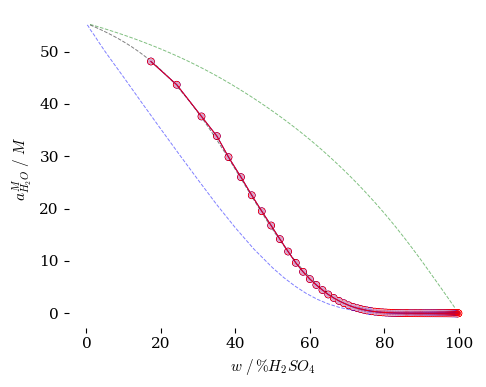

In [228]:
### Plot scanned data for Giauque and Zeleznick fro Zeleznick paper Figure 25B

######################################################
### get data from Zeleznick scan of figure 25B
######################################################

## Convert u_r data from figure 25 of Zeleznick to osmitic coefficient and then to activity
## https://en.wikipedia.org/wiki/Thermodynamic_activity

###################################################### read data
Data_File_Name = "01-Zeleznick_F25B_scanned.csv"     # data file name
Filename = github_location + Data_File_Name          # location of data file

df = pd.read_csv(Filename,                           # read data file
                 delimiter = ",",                    # delimiter is comma for csv
                 skipinitialspace=True,              # skip spaces after delimiter
                 index_col=False,                    # no index column
                 comment = "#"                       # comment character
                 ) 

###################################################### extract data and convert
x = df["x"].to_numpy()                               # mole fraction H2SO4
w2 = convert_x_to_w(x)                               # convert to w %H2SO4

ur = df["u_r"].to_numpy()                            # reduced chemical potential
a_w = np.exp(-ur)                                    # Chemical potential to aH2O_pxp0 activity
molar_a_H2O_z2 = convert_aH2O_pxp0_to_MxM0(w2, a_w)  # convert aH2O to molar activity of H2O (aH2O_MxM0)

###################################################### store results in dataframe
df_Z_F25B_Z = pd.DataFrame({"w":w2,                  # %H2So4
                            "c": molar_a_H2O_z2})    # molar activity of H2O (aH2O_MxM0)

######################################################
### get Giaque data from Zeleznick scan of figure 25B
######################################################

## Convert u_r data from figure 25 of Zeleznick to osmitic coefficient and then to activity
## https://en.wikipedia.org/wiki/Thermodynamic_activity

###################################################### read data
Data_File_Name = "01-Zeleznick_F25B_scanned_giauque.csv"     # data file name
Filename = github_location + Data_File_Name          # location of data file

df = pd.read_csv(Filename,                           # read data file
                 delimiter = ",",                    # delimiter is comma for csv
                 skipinitialspace=True,              # skip spaces after delimiter
                 index_col=False,                    # no index column
                 comment = "#"                       # comment character
                 ) 

###################################################### extract data and convert
x = df["x"].to_numpy()                               # mole fraction H2SO4
w2 = convert_x_to_w(x)                               # convert to w %H2SO4

ur = df["u_r"].to_numpy()                            # reduced chemical potential
a_w = np.exp(-ur)                                    # Chemical potential to aH2O_pxp0 activity
molar_a_H2O_z2 = convert_aH2O_pxp0_to_MxM0(w2, a_w)  # convert aH2O to molar activity of H2O (aH2O_MxM0)

###################################################### store results in dataframe
df_Z_F25B_G = pd.DataFrame({"w":w2,                  # %H2SO4
                            "c": molar_a_H2O_z2})    # molar activity of H2O (aH2O_MxM0)



######################################################
### Plot scanned data for Giauque and Zeleznick fro Zeleznick paper Figure 25B
######################################################

###################################################### set up plot figure, axes and labels
style = "tufte.mplstyle"                             # style file name
style_name = github_location_styles + style          # full path to style file 
plt.style.use(style_name)                            # use style file

fig, ax = plt.subplots(nrows=1, ncols=1,             # create figure and axes
                       figsize=(5,4))                # figure size

ax.set(                                              # set plot parameters
#          title = Title0,                            # plot title
          xlabel=r"$w\ /\,\%H_2SO_4$",               # x axis label                
          ylabel=r"$a^M_{H_2O}\ /\;M$",              # y axis label 
#          xlim=[-2,102],                             # x axis limits
#          ylim=[-6,2]                                # y axis limits
       )

###################################################### plot Zeleznick scanned data
x = df_Z_F25B_Z["w"]                                 # %H2SO4
y = np.log10(df_Z_F25B_Z["c"])                       # molar activity of H2O (aH2O_MxM0)
y = df_Z_F25B_Z["c"]

ax.plot(x, y,                                        # plot line
          marker = None,  
          color = "blue", linewidth=0.7, 
          alpha = 1,
          zorder = 11)
if 1:                                                # only plot points if needed
    ax.scatter(x, y,                                  
          marker = "o", s = 30, 
          color = "blue", edgecolors = "none", linewidths=0, 
          zorder = 3)
    ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 4)
    ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "blue", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 5)



###################################################### plot Giauque scanned data from Zeleznick
x = df_Z_F25B_G["w"]                                 # %H2SO4
y = np.log10(df_Z_F25B_G["c"])                       # molar activity of H2O (aH2O_MxM0)
y = df_Z_F25B_G["c"]

ax.plot(x, y,                                        # plot line
          marker = None,  
          color = "red", linewidth=0.7, 
          alpha = 1,
          zorder = 11)
if 1:                                                # only plot points if needed
    ax.scatter(x, y,                                  
          marker = "o", s = 30, 
          color = "red", edgecolors = "none", linewidths=0, 
          zorder = 3)
    ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 4)
    ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "red", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 5)


###################################################### plot molar concentration of water
x = df1["w"]                                         # set x-axis to %H2SO4
molar_H2O = molar_H2O_from_w(x)                      # calculate molar concentration of H2O
y = np.log10(molar_H2O)                              # set y-axis to log10 of molar concentration of H2O
y = molar_H2O                                       # or set y-axis to molar concentration of H2O

ax.plot(x, y, 
          marker = None,  
          color = "green", linewidth=0.7, linestyle='--',
          alpha = 0.5,
          zorder = 0)


###################################################### plot Giauque literature data points
x = df1["w"]                                         # set x-axis to %H2SO4
y = np.log10(df1["M_aH2O"])                          # set y-axis to log10 of molar activity of H2O
y = df1["M_aH2O"]                                   # or set y-axis to molar activity of H2O
#print(y[-10:])

ax.plot(x, y,                                        # plot line
          marker = None,  
          color = "black", linewidth=0.7, linestyle='--',
          alpha = 0.5,
          zorder = 3)
if 0:                                                # only plot points if needed
    ax.scatter(x, y,                                  
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 3)
    ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 4)
    ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "black", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 5)


###################################################### plot Cox literature data points
x = df_cox_T3["w"]
y = np.log10(df_cox_T3["M_aH2O"])
y = df_cox_T3["M_aH2O"]
#print(x[-10:])

ax.plot(x, y,                                        # plot line
          marker = None,  
          color = "blue", linewidth=0.7, linestyle='--',
          alpha = 0.5,
          zorder = 3)

if 0:                                                # only plot points if needed
    ax.scatter(x, y, 
              marker = "o", s = 30, 
              color = "black", edgecolors = "none", linewidths=0, 
              zorder = 6)

    ax.scatter(x, y, 
              marker = "o", s = 17, 
              color = "white", edgecolors = "none", linewidths=0, 
              zorder = 7)

    ax.scatter(x, y, 
              marker = "o", s = 17, 
              color = "blue", edgecolors = "none", linewidths=0, 
              alpha = 0.2,
              zorder = 8)


###################################################### plot Zeleznick table 8 data
x = w_z
y = np.log10(molar_a_H2O_z)
#y = molar_a_H2O_z
print(y[-10:])
print(x[-10:])
#ax.plot(x, y, 
#          marker = None,  
#          color = "white", linewidth=1.5, 
#          alpha = 1,
#          zorder = 10)
#ax.plot(x, y, 
#          marker = None,  
#          color = "purple", linewidth=0.7, 
#          alpha = 1,
#          zorder = 0)



plt.savefig("plots/plot_H4a.pdf")
plt.show()
